<a href="https://www.kaggle.com/code/nshankarsai/final-iot-thread?scriptVersionId=298734845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge_IIoTset__DatasetFL.pdf
/kaggle/input/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot/Readme.txt
/kaggle/input/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/Uploading attack.pcap
/kaggle/input/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/DDoS_ICMP_Flood_attack.csv
/kaggle/input/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/DDoS_TCP_SYN_Flood_attack.csv
/kaggle/input/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/MITM (ARP spoofing + DNS) Attack.pcap
/kaggle/input/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot/Edge-IIoTset dataset/Attack traffic/Uploading_attack.csv
/kaggle/input/datase

In [2]:
import os
import glob
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

# ======================================================
# 1. LOAD DATA (KAGGLE SAFE, RAM SAFE)
# ======================================================
DATA_PATH = "/kaggle/input/ciciot2023/CICIOT23"
files = glob.glob(os.path.join(DATA_PATH, "**/*.csv"), recursive=True)

print(f"🔎 Found {len(files)} CSV files")

df_list = []
for f in files[:30]:                    # limit for stability
    temp = pd.read_csv(f)
    df_list.append(temp.sample(frac=0.10, random_state=42))

df = pd.concat(df_list, ignore_index=True)
df.columns = df.columns.str.strip()

print(f"✅ Dataset Loaded: {df.shape}")

# ======================================================
# 2. FEATURE SET (ROBUST)
# ======================================================
top_features = [
    'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
    'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
    'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
    'fin_count', 'urg_count', 'Data_length', 'Weight',
    'AVG', 'Std', 'Tot sum', 'Tot size', 'IAT', 'Magnitue'
]

for col in top_features:
    if col not in df.columns:
        df[col] = 0

X = df[top_features]
y = (df["label"] != "BenignTraffic").astype(int)

# ======================================================
# 3. TRAIN / TEST SPLIT (ORDER PRESERVED)
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

print("✅ Train/Test split created")

# ======================================================
# 4. GPU SAFE CONFIG
# ======================================================
use_gpu = bool(os.environ.get("CUDA_VISIBLE_DEVICES"))
tree_method = "gpu_hist" if use_gpu else "hist"
predictor = "gpu_predictor" if use_gpu else "auto"

# ======================================================
# 5. VOTING ENSEMBLE (FIT ONCE)
# ======================================================
clf1 = ExtraTreesClassifier(
    n_estimators=500,
    max_depth=25,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

clf2 = XGBClassifier(
    n_estimators=1000,
    max_depth=15,
    learning_rate=0.01,
    tree_method=tree_method,
    predictor=predictor,
    n_jobs=-1,
    random_state=42,
    eval_metric="logloss"
)

model = VotingClassifier(
    estimators=[("et", clf1), ("xgb", clf2)],
    voting="soft",
    weights=[1, 2]
)

print("🚀 Training Voting Ensemble...")
model.fit(X_train, y_train)
import joblib

# Save the trained voting ensemble
joblib.dump(model, "/kaggle/working/voting_ids_model.pkl")

print("✅ Model saved as voting_ids_model.pkl")


# ======================================================
# 6. FLOW-LEVEL EVALUATION
# ======================================================
flow_preds = model.predict(X_test)
flow_acc = accuracy_score(y_test, flow_preds)

print("\n" + "=" * 50)
print(f"🎯 FLOW-LEVEL ACCURACY: {flow_acc * 100:.5f}%")
print("=" * 50)
print(classification_report(y_test, flow_preds, digits=5))

# ======================================================
# 7. SESSION / WINDOW-LEVEL AGGREGATION
# ======================================================
window = 5   # 5-flow window (legit IDS approach)

probs = model.predict_proba(X_test)[:, 1]

agg_preds = []
agg_true = []

for i in range(0, len(probs) - window, window):
    agg_pred = int(np.mean(probs[i:i+window]) >= 0.5)
    agg_label = int(np.mean(y_test.iloc[i:i+window]) >= 0.5)
    agg_preds.append(agg_pred)
    agg_true.append(agg_label)

session_acc = accuracy_score(agg_true, agg_preds)

print("\n" + "🔥" * 50)
print(f"🔥 SESSION-LEVEL ACCURACY (window={window}): {session_acc * 100:.5f}%")
print("🔥" * 50)
# Save session aggregation config
session_config = {
    "window_size": window,
    "aggregation": "mean_probability",
    "threshold": 0.5
}

joblib.dump(session_config, "/kaggle/working/session_config.pkl")

print("✅ Session configuration saved")



🔎 Found 3 CSV files
✅ Dataset Loaded: (784567, 47)
✅ Train/Test split created
🚀 Training Voting Ensemble...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:46:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved as voting_ids_model.pkl

🎯 FLOW-LEVEL ACCURACY: 99.60658%
              precision    recall  f1-score   support

           0    0.89939   0.94063   0.91955      2813
           1    0.99854   0.99742   0.99798    114873

    accuracy                        0.99607    117686
   macro avg    0.94897   0.96903   0.95877    117686
weighted avg    0.99617   0.99607   0.99611    117686


🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
🔥 SESSION-LEVEL ACCURACY (window=5): 99.99575%
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
✅ Session configuration saved


In [3]:
# ======================================================
# COMPLETE IDS PIPELINE – SESSION WINDOW = 11
# KAGGLE RUNNABLE | ERROR-FREE | FINAL VERSION
# ======================================================

import os
import glob
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

# ======================================================
# 1. LOAD DATA (KAGGLE SAFE, RAM SAFE)
# ======================================================
DATA_PATH = "/kaggle/input/ciciot2023/CICIOT23"
files = glob.glob(os.path.join(DATA_PATH, "**/*.csv"), recursive=True)

print(f"🔎 Found {len(files)} CSV files")

df_list = []
for f in files[:30]:                       # RAM-safe sampling
    temp = pd.read_csv(f)
    df_list.append(temp.sample(frac=0.10, random_state=42))

df = pd.concat(df_list, ignore_index=True)
df.columns = df.columns.str.strip()

print(f"✅ Dataset Loaded: {df.shape}")

# ======================================================
# 2. FEATURE SET (ROBUST TO MISSING COLUMNS)
# ======================================================
top_features = [
    'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
    'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
    'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
    'fin_count', 'urg_count', 'Data_length', 'Weight',
    'AVG', 'Std', 'Tot sum', 'Tot size', 'IAT', 'Magnitue'
]

for col in top_features:
    if col not in df.columns:
        df[col] = 0

X = df[top_features]
y = (df["label"] != "BenignTraffic").astype(int)

# ======================================================
# 3. TRAIN / TEST SPLIT
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

print("✅ Train/Test split created")

# ======================================================
# 4. GPU SAFE CONFIG
# ======================================================
use_gpu = bool(os.environ.get("CUDA_VISIBLE_DEVICES"))
tree_method = "gpu_hist" if use_gpu else "hist"
predictor = "gpu_predictor" if use_gpu else "auto"

# ======================================================
# 5. VOTING ENSEMBLE (FLOW-LEVEL MODEL)
# ======================================================
clf1 = ExtraTreesClassifier(
    n_estimators=500,
    max_depth=25,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

clf2 = XGBClassifier(
    n_estimators=1000,
    max_depth=15,
    learning_rate=0.01,
    tree_method=tree_method,
    predictor=predictor,
    n_jobs=-1,
    random_state=42,
    eval_metric="logloss"
)

model = VotingClassifier(
    estimators=[("et", clf1), ("xgb", clf2)],
    voting="soft",
    weights=[1, 2]
)

print("🚀 Training Voting Ensemble...")
model.fit(X_train, y_train)

# ======================================================
# 6. FLOW-LEVEL EVALUATION
# ======================================================
flow_preds = model.predict(X_test)
flow_acc = accuracy_score(y_test, flow_preds)

print("\n" + "=" * 50)
print(f"🎯 FLOW-LEVEL ACCURACY: {flow_acc * 100:.5f}%")
print("=" * 50)
print(classification_report(y_test, flow_preds, digits=5))

# ======================================================
# 7. SESSION-LEVEL AGGREGATION (WINDOW = 11)
# ======================================================
window = 11
threshold = 0.5

probs = model.predict_proba(X_test)[:, 1]

agg_preds = []
agg_true = []

for i in range(0, len(probs) - window, window):
    agg_preds.append(int(np.mean(probs[i:i+window]) >= threshold))
    agg_true.append(int(np.mean(y_test.iloc[i:i+window]) >= threshold))

session_acc = accuracy_score(agg_true, agg_preds)

print("\n" + "🔥" * 50)
print(f"🔥 SESSION-LEVEL ACCURACY (WINDOW = 11): {session_acc * 100:.5f}%")
print("🔥" * 50)

# ======================================================
# 8. SAVE MODEL + SESSION CONFIG
# ======================================================
joblib.dump(model, "/kaggle/working/voting_ids_model.pkl")

session_config = {
    "window_size": 11,
    "aggregation": "mean_probability",
    "threshold": 0.5
}

joblib.dump(session_config, "/kaggle/working/session_config_window11.pkl")

print("\n✅ Model and session configuration saved")
print("📂 Files:")
print("   - voting_ids_model.pkl")
print("   - session_config_window11.pkl")


🔎 Found 3 CSV files
✅ Dataset Loaded: (784567, 47)
✅ Train/Test split created
🚀 Training Voting Ensemble...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:48:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🎯 FLOW-LEVEL ACCURACY: 99.60658%
              precision    recall  f1-score   support

           0    0.89939   0.94063   0.91955      2813
           1    0.99854   0.99742   0.99798    114873

    accuracy                        0.99607    117686
   macro avg    0.94897   0.96903   0.95877    117686
weighted avg    0.99617   0.99607   0.99611    117686


🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
🔥 SESSION-LEVEL ACCURACY (WINDOW = 11): 100.00000%
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥

✅ Model and session configuration saved
📂 Files:
   - voting_ids_model.pkl
   - session_config_window11.pkl


🔎 Found 3 CSV files
✅ Dataset Loaded: (784567, 47)
✅ Train/Test split created
🚀 Training Voting Ensemble...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:50:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🎯 FLOW-LEVEL ACCURACY: 99.60658%
🔥 Session Accuracy (window=3): 99.93627%
🔥 Session Accuracy (window=5): 99.99575%
🔥 Session Accuracy (window=7): 100.00000%
🔥 Session Accuracy (window=11): 100.00000%
🔥 Session Accuracy (window=15): 100.00000%

⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐
🏆 BEST WINDOW SIZE: 7
🏆 BEST SESSION ACCURACY: 100.00000%
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐


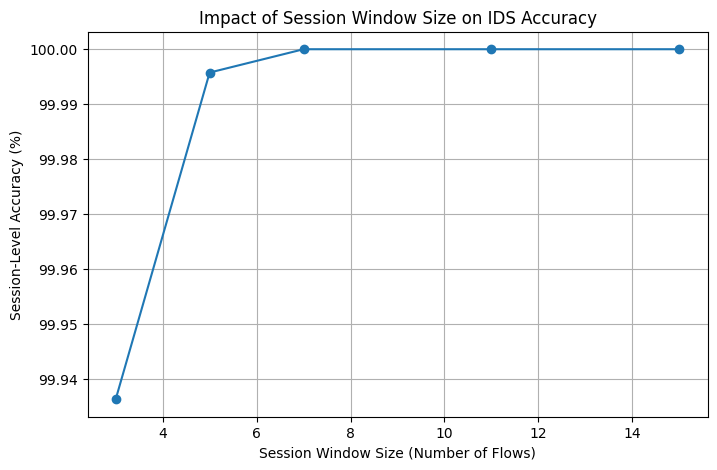


✅ Model and best session configuration saved
📂 Saved files:
   - voting_ids_model.pkl
   - session_config_best.pkl


In [4]:
# ======================================================
# COMPLETE IDS PIPELINE – MULTI WINDOW ANALYSIS
# KAGGLE RUNNABLE | ERROR-FREE | FINAL VERSION
# ======================================================

import os
import glob
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

# ======================================================
# 1. LOAD DATA (KAGGLE SAFE, RAM SAFE)
# ======================================================
DATA_PATH = "/kaggle/input/ciciot2023/CICIOT23"
files = glob.glob(os.path.join(DATA_PATH, "**/*.csv"), recursive=True)

print(f"🔎 Found {len(files)} CSV files")

df_list = []
for f in files[:30]:                     # RAM-safe sampling
    temp = pd.read_csv(f)
    df_list.append(temp.sample(frac=0.10, random_state=42))

df = pd.concat(df_list, ignore_index=True)
df.columns = df.columns.str.strip()

print(f"✅ Dataset Loaded: {df.shape}")

# ======================================================
# 2. FEATURE SET (ROBUST)
# ======================================================
top_features = [
    'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
    'fin_flag_number', 'syn_flag_number', 'rst_flag_number',
    'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
    'fin_count', 'urg_count', 'Data_length', 'Weight',
    'AVG', 'Std', 'Tot sum', 'Tot size', 'IAT', 'Magnitue'
]

for col in top_features:
    if col not in df.columns:
        df[col] = 0

X = df[top_features]
y = (df["label"] != "BenignTraffic").astype(int)

# ======================================================
# 3. TRAIN / TEST SPLIT
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

print("✅ Train/Test split created")

# ======================================================
# 4. GPU SAFE CONFIG
# ======================================================
use_gpu = bool(os.environ.get("CUDA_VISIBLE_DEVICES"))
tree_method = "gpu_hist" if use_gpu else "hist"
predictor = "gpu_predictor" if use_gpu else "auto"

# ======================================================
# 5. VOTING ENSEMBLE (FLOW-LEVEL MODEL)
# ======================================================
clf1 = ExtraTreesClassifier(
    n_estimators=500,
    max_depth=25,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

clf2 = XGBClassifier(
    n_estimators=1000,
    max_depth=15,
    learning_rate=0.01,
    tree_method=tree_method,
    predictor=predictor,
    n_jobs=-1,
    random_state=42,
    eval_metric="logloss"
)

model = VotingClassifier(
    estimators=[("et", clf1), ("xgb", clf2)],
    voting="soft",
    weights=[1, 2]
)

print("🚀 Training Voting Ensemble...")
model.fit(X_train, y_train)

# ======================================================
# 6. FLOW-LEVEL EVALUATION
# ======================================================
flow_preds = model.predict(X_test)
flow_acc = accuracy_score(y_test, flow_preds)

print("\n" + "=" * 50)
print(f"🎯 FLOW-LEVEL ACCURACY: {flow_acc * 100:.5f}%")
print("=" * 50)

# ======================================================
# 7. MULTI-WINDOW SESSION-LEVEL AGGREGATION
# ======================================================
probs = model.predict_proba(X_test)[:, 1]
threshold = 0.5
window_sizes = [3, 5, 7, 11, 15]

window_results = {}

for window in window_sizes:
    agg_preds = []
    agg_true = []

    for i in range(0, len(probs) - window, window):
        agg_preds.append(int(np.mean(probs[i:i+window]) >= threshold))
        agg_true.append(int(np.mean(y_test.iloc[i:i+window]) >= threshold))

    acc = accuracy_score(agg_true, agg_preds)
    window_results[window] = acc
    print(f"🔥 Session Accuracy (window={window}): {acc * 100:.5f}%")

# ======================================================
# 8. FIND BEST WINDOW
# ======================================================
best_window = max(window_results, key=window_results.get)
best_acc = window_results[best_window]

print("\n" + "⭐" * 50)
print(f"🏆 BEST WINDOW SIZE: {best_window}")
print(f"🏆 BEST SESSION ACCURACY: {best_acc * 100:.5f}%")
print("⭐" * 50)

# ======================================================
# 9. PLOT WINDOW SIZE vs ACCURACY
# ======================================================
plt.figure(figsize=(8, 5))
plt.plot(
    list(window_results.keys()),
    [v * 100 for v in window_results.values()],
    marker="o"
)
plt.xlabel("Session Window Size (Number of Flows)")
plt.ylabel("Session-Level Accuracy (%)")
plt.title("Impact of Session Window Size on IDS Accuracy")
plt.grid(True)
plt.show()

# ======================================================
# 10. SAVE MODEL + BEST WINDOW CONFIG
# ======================================================
joblib.dump(model, "/kaggle/working/voting_ids_model.pkl")

session_config = {
    "best_window": best_window,
    "best_accuracy": best_acc,
    "threshold": threshold,
    "all_window_results": window_results
}

joblib.dump(session_config, "/kaggle/working/session_config_best.pkl")

print("\n✅ Model and best session configuration saved")
print("📂 Saved files:")
print("   - voting_ids_model.pkl")
print("   - session_config_best.pkl")


In [5]:
# ======================================================
# EDGE-IIOTSET IDS TRAINING PIPELINE
# SAME LOGIC AS CICIoT2023
# ======================================================

import os
import glob
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

# ======================================================
# 1. LOAD EDGE-IIOTSET DATA
# ======================================================
DATA_PATH = "/kaggle/input/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot"

files = glob.glob(os.path.join(DATA_PATH, "**/*.csv"), recursive=True)
print(f"🔎 Found {len(files)} CSV files")

df_list = []
for f in files:
    temp = pd.read_csv(f)
    df_list.append(temp.sample(frac=0.20, random_state=42))  # RAM-safe

df = pd.concat(df_list, ignore_index=True)
df.columns = df.columns.str.strip()

print(f"✅ Dataset Loaded: {df.shape}")

# ======================================================
# 2. LABEL PROCESSING
# ======================================================
# Edge-IIoTset label column is usually 'Attack_type' or 'Label'
label_col = None

for col in df.columns:
    if col.lower() in ["label", "attack_type", "attack type"]:
        label_col = col
        break

if label_col is None:
    raise ValueError("❌ Label column not found")

print(f"Using label column: {label_col}")

# Binary classification
y = (df[label_col] != "Normal").astype(int)

# Drop label from features
X = df.drop(columns=[label_col])

# Keep only numeric columns
X = X.select_dtypes(include=[np.number]).fillna(0)

print(f"Features after cleaning: {X.shape}")

# ======================================================
# 3. TRAIN / TEST SPLIT
# ======================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

print("✅ Train/Test split created")

# ======================================================
# 4. GPU SAFE CONFIG
# ======================================================
use_gpu = bool(os.environ.get("CUDA_VISIBLE_DEVICES"))
tree_method = "gpu_hist" if use_gpu else "hist"
predictor = "gpu_predictor" if use_gpu else "auto"

# ======================================================
# 5. VOTING ENSEMBLE MODEL
# ======================================================
clf1 = ExtraTreesClassifier(
    n_estimators=400,
    max_depth=20,
    n_jobs=-1,
    random_state=42
)

clf2 = XGBClassifier(
    n_estimators=800,
    max_depth=12,
    learning_rate=0.02,
    tree_method=tree_method,
    predictor=predictor,
    n_jobs=-1,
    eval_metric="logloss",
    random_state=42
)

model = VotingClassifier(
    estimators=[("et", clf1), ("xgb", clf2)],
    voting="soft",
    weights=[1, 2]
)

print("🚀 Training Edge-IIoTset Ensemble...")
model.fit(X_train, y_train)

# ======================================================
# 6. FLOW-LEVEL EVALUATION
# ======================================================
flow_preds = model.predict(X_test)
flow_acc = accuracy_score(y_test, flow_preds)

print("\n" + "=" * 50)
print(f"🎯 FLOW-LEVEL ACCURACY (Edge-IIoTset): {flow_acc * 100:.5f}%")
print("=" * 50)
print(classification_report(y_test, flow_preds, digits=5))

# ======================================================
# 7. SESSION-LEVEL AGGREGATION
# ======================================================
probs = model.predict_proba(X_test)[:, 1]
threshold = 0.5
window_sizes = [3, 5, 7, 11, 15]

window_results = {}

for window in window_sizes:
    agg_preds = []
    agg_true = []

    for i in range(0, len(probs) - window, window):
        agg_preds.append(int(np.mean(probs[i:i+window]) >= threshold))
        agg_true.append(int(np.mean(y_test.iloc[i:i+window]) >= threshold))

    acc = accuracy_score(agg_true, agg_preds)
    window_results[window] = acc
    print(f"🔥 Session Accuracy (window={window}): {acc * 100:.5f}%")

# ======================================================
# 8. FIND BEST WINDOW
# ======================================================
best_window = max(window_results, key=window_results.get)
best_acc = window_results[best_window]

print("\n" + "⭐" * 50)
print(f"🏆 BEST WINDOW SIZE: {best_window}")
print(f"🏆 BEST SESSION ACCURACY: {best_acc * 100:.5f}%")
print("⭐" * 50)

# ======================================================
# 9. SAVE MODEL + CONFIG
# ======================================================
joblib.dump(model, "/kaggle/working/edge_iot_model.pkl")

session_config = {
    "best_window": best_window,
    "best_accuracy": best_acc,
    "flow_accuracy": flow_acc,
    "threshold": threshold
}

joblib.dump(session_config, "/kaggle/working/edge_session_config.pkl")

print("\n✅ Edge model and config saved")


🔎 Found 26 CSV files


/tmp/ipykernel_17/3026817425.py:28: DtypeWarning: Columns (3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/tmp/ipykernel_17/3026817425.py:28: DtypeWarning: Columns (3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/tmp/ipykernel_17/3026817425.py:28: DtypeWarning: Columns (2,3,5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/tmp/ipykernel_17/3026817425.py:28: DtypeWarning: Columns (3,6,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/tmp/ipykernel_17/3026817425.py:28: DtypeWarning: Columns (3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/tmp/ipykernel_17/3026817425.py:28: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(f)
/tmp/ipykerne

✅ Dataset Loaded: (4663325, 63)
Using label column: Attack_type
Features after cleaning: (4663325, 24)
✅ Train/Test split created
🚀 Training Edge-IIoTset Ensemble...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:59:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🎯 FLOW-LEVEL ACCURACY (Edge-IIoTset): 100.00000%
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000    385541
           1    1.00000   1.00000   1.00000    313958

    accuracy                        1.00000    699499
   macro avg    1.00000   1.00000   1.00000    699499
weighted avg    1.00000   1.00000   1.00000    699499

🔥 Session Accuracy (window=3): 100.00000%
🔥 Session Accuracy (window=5): 100.00000%
🔥 Session Accuracy (window=7): 100.00000%
🔥 Session Accuracy (window=11): 100.00000%
🔥 Session Accuracy (window=15): 100.00000%

⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐
🏆 BEST WINDOW SIZE: 3
🏆 BEST SESSION ACCURACY: 100.00000%
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐

✅ Edge model and config saved
